In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = .5
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5
plt.rcParams['xtick.minor.width'] = .0
plt.rcParams['ytick.minor.width'] = .0
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['font.size'] = 6

In [3]:
# read grid
betas = np.loadtxt('grid_betas')
nlats = np.loadtxt('grid_nlats').astype(int)

# read data
LCM = np.load('results/metric_LCM.npy')
MIG = np.load('results/metric_MIG.npy')
AAD = np.load('results/metric_AAD.npy')
REC = np.load('results/metric_REC.npy')
KL = np.load('results/metric_KL.npy')
LOSS = np.load('results/metric_LOSS.npy')

REC /= 4096
LOSS /= 4096
KL /= nlats

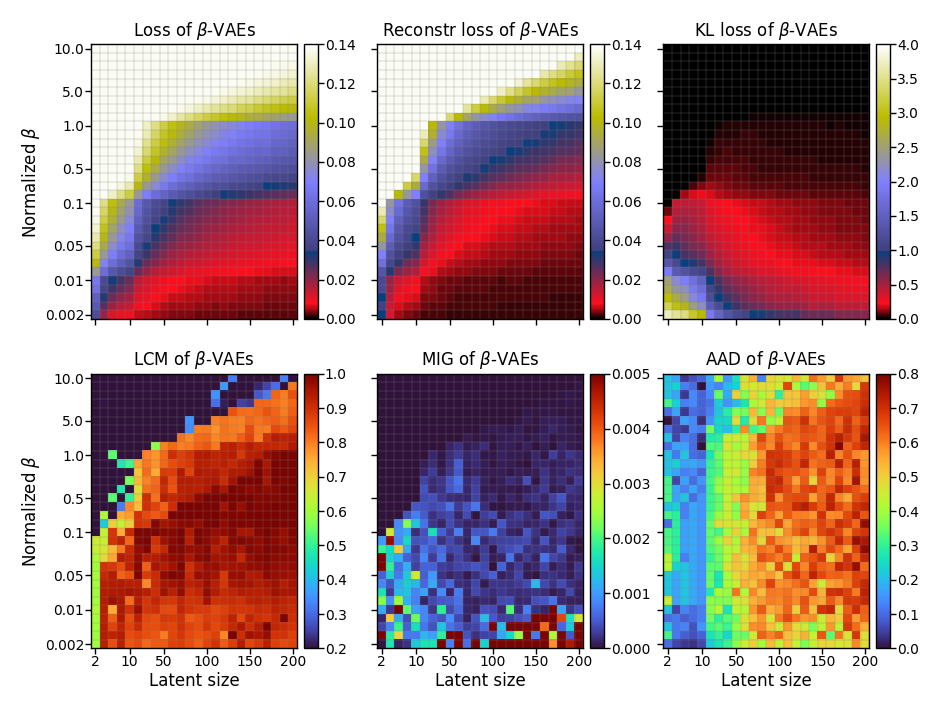

In [13]:
xticks_id = [0, 4, 8, 13, 18, 23]
xticks = nlats[::-1][xticks_id]
yticks_id = [0, 4, 8, 13, 17, 22, 26, 31]
yticks = betas[yticks_id]

fig, axes = plt.subplots(nrows=2, ncols=3, dpi=200, facecolor='w')
plt.subplots_adjust(wspace=-.2)

cm_loss = 'gist_stern'
cm_metric = 'turbo'


# loss
ax = axes[0, 0]
im = ax.imshow(LOSS[:, ::-1], origin='lower', cmap=cm_loss, vmin=0, vmax=.14)
cbar = fig.colorbar(im, ax=ax, pad=.02)
cbar.ax.tick_params('both', length=2, pad=0.5, which='major', labelsize=5)
ax.set_xticks(xticks_id)
ax.set_yticks(yticks_id)
ax.set_xticklabels([])
ax.set_yticklabels(yticks, fontsize=5)
ax.set_ylabel(r'Normalized $\beta$')
ax.set_title(r'Loss of $\beta$-VAEs', fontsize=6)
ax.tick_params('both', length=2, width=.5, pad=0.5, which='major')
ax.set_xticks(np.arange(len(nlats)) + .5, minor=True)
ax.set_yticks(np.arange(len(betas)) + .5, minor=True)
ax.grid(which='minor', c='gray', lw=.1)

# rec
ax = axes[0, 1]
im = ax.imshow(REC[:, ::-1], origin='lower', cmap=cm_loss, vmin=0, vmax=.14)
cbar = fig.colorbar(im, ax=ax, pad=.02)
cbar.ax.tick_params('both', length=2, pad=0.5, which='major', labelsize=5)
ax.set_xticks(xticks_id)
ax.set_yticks(yticks_id)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title(r'Reconstr loss of $\beta$-VAEs', fontsize=6)
ax.tick_params('both', length=2, width=.5, pad=0.5, which='major')
ax.set_xticks(np.arange(len(nlats)) + .5, minor=True)
ax.set_yticks(np.arange(len(betas)) + .5, minor=True)
ax.grid(which='minor', c='gray', lw=.1)

# KL
ax = axes[0, 2]
im = ax.imshow(KL[:, ::-1], origin='lower', cmap=cm_loss, vmin=0, vmax=4)
cbar = fig.colorbar(im, ax=ax, pad=.02)
cbar.ax.tick_params('both', length=2, pad=0.5, which='major', labelsize=5)
ax.set_xticks(xticks_id)
ax.set_yticks(yticks_id)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title(r'KL loss of $\beta$-VAEs', fontsize=6)
ax.tick_params('both', length=2, width=.5, pad=0.5, which='major')
ax.set_xticks(np.arange(len(nlats)) + .5, minor=True)
ax.set_yticks(np.arange(len(betas)) + .5, minor=True)
ax.grid(which='minor', c='gray', lw=.1)

# LCM
ax = axes[1, 0]
im = ax.imshow(LCM[:, ::-1], origin='lower', cmap=cm_metric, vmin=0.2, vmax=1.)
cbar = fig.colorbar(im, ax=ax, pad=.02)
cbar.ax.tick_params('both', length=2, pad=0.5, which='major', labelsize=5)
ax.set_xticks(xticks_id)
ax.set_yticks(yticks_id)
ax.set_xticklabels(xticks, fontsize=5)
ax.set_yticklabels(yticks, fontsize=5)
ax.set_xlabel(r'Latent size')
ax.set_ylabel(r'Normalized $\beta$')
ax.set_title(r'LCM of $\beta$-VAEs', fontsize=6)
ax.tick_params('both', length=2, width=.5, pad=0.5, which='major')
ax.set_xticks(np.arange(len(nlats)) + .5, minor=True)
ax.set_yticks(np.arange(len(betas)) + .5, minor=True)
ax.grid(which='minor', c='gray', lw=.1)

# MIG
ax = axes[1, 1]
im = ax.imshow(MIG[:, ::-1], origin='lower', cmap=cm_metric, vmin=0, vmax=.005)
cbar = fig.colorbar(im, ax=ax, pad=.02)
cbar.ax.tick_params('both', length=2, pad=0.5, which='major', labelsize=5)
ax.set_xticks(xticks_id)
ax.set_yticks(yticks_id)
ax.set_xticklabels(xticks, fontsize=5)
ax.set_yticklabels([])
ax.set_xlabel(r'Latent size')
ax.set_title(r'MIG of $\beta$-VAEs', fontsize=6)
ax.tick_params('both', length=2, width=.5, pad=0.5, which='major')
ax.set_xticks(np.arange(len(nlats)) + .5, minor=True)
ax.set_yticks(np.arange(len(betas)) + .5, minor=True)
ax.grid(which='minor', c='gray', lw=.1)

# AAD
ax = axes[1, 2]
im = ax.imshow(AAD[:, ::-1], origin='lower', cmap=cm_metric, vmin=0, vmax=.8)
cbar = fig.colorbar(im, ax=ax, pad=.02)
cbar.ax.tick_params('both', length=2, pad=0.5, which='major', labelsize=5)
ax.set_xticks(xticks_id)
ax.set_yticks(yticks_id)
ax.set_xticklabels(xticks, fontsize=5)
ax.set_yticklabels([])
ax.set_xlabel(r'Latent size')
ax.set_title(r'AAD of $\beta$-VAEs', fontsize=6)
ax.tick_params('both', length=2, width=.5, pad=0.5, which='major')
ax.set_xticks(np.arange(len(nlats)) + .5, minor=True)
ax.set_yticks(np.arange(len(betas)) + .5, minor=True)
ax.grid(which='minor', c='gray', lw=.1)

# save
plt.savefig('metrics.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

In [ ]:
hist_rec = np.load('results/hist_rec.npy')
hist_KL = np.load('results/hist_KL.npy')
hist_loss = np.load('results/hist_loss.npy')

fig, axes = plt.subplots(nrows=len(betas), ncols=len(nlats), dpi=200, facecolor='w')
for i in range(len(betas)):
    for j in range(len(nlats)):
        axes[i, j].plot(hist_loss[i, j].reshape(-1), c='k', lw=.2)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].axis('off')
plt.show()

fig, axes = plt.subplots(nrows=len(betas), ncols=len(nlats), dpi=200, facecolor='w')
for i in range(len(betas)):
    for j in range(len(nlats)):
        axes[i, j].plot(hist_rec[i, j].reshape(-1), c='k', lw=.2)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].axis('off')
plt.show()

fig, axes = plt.subplots(nrows=len(betas), ncols=len(nlats), dpi=200, facecolor='w')
for i in range(len(betas)):
    for j in range(len(nlats)):
        axes[i, j].plot(hist_KL[i, j].reshape(-1), c='k', lw=.2)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].axis('off')
plt.show()